Prediction model for static 3D soil properties
-----------------------------------------------

This notebook generates soil Organic Carbon predictions at multiple soil depths at one given time. 

The model training data is based on soil data taken at sample sites in L'lara. 

The prediction model that is selected here is based on Gaussian Process regression with Bayesian Linear regression as base function. 

The Gaussian Process models the spatial land temporal correlations between data and prediction locations. 
Here we use a squared exponential kernel with two joint length-scales, one for spatial and one for temporal distance (see optimized hyperparameters of the GP below).

User settings, such as input/output paths and all other options, are set in the settings file, e.g.:

`settings_soilmod_predict_static.yaml`

Model and features have been selected in the previous workflow steps (see notebooks `soilmodel_xval_static.ipynb` and `feature_importance_static.ipynb`).

This package is part of the machine learning project developed for the Agricultural Research Federation (AgReFed).



## Library imports

In [1]:
# Import libraries
import os 
import sys
import yaml
from types import SimpleNamespace  
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Import model 
sys.path.append('../python_scripts')
import soilmod_predict as soilmod


 ## Settings file

 All settings are specified in the .yaml file to make analysis repeatable.

In [2]:
# Define name of settings file to save configuration
fname_settings = 'settings_soilmod_predict_static.yaml'
path_settings = 'settings'

### Reading and process settings

In [3]:
# Load settings from yaml file
with open(os.path.join(path_settings,fname_settings), 'r') as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)
# Parse settings dictionary as namespace (settings are available as 
# settings.variable_name rather than settings['variable_name'])
settings = SimpleNamespace(**settings)

# Verify output directory and make it if it does not exist
os.makedirs(settings.outpath, exist_ok = True)

print("Main Settings:")
print("----------------")
for key in settings.__dict__:
    if key != "name_features":
        print(f"settings.{key} : {settings.__dict__[key]}")

Main Settings:
----------------
settings.inpath : ../../../data/Llara/
settings.outpath : ../../../results/Llara_predictions_static3d/
settings.infname : soildata_static3d.csv
settings.gridname : Llara_COVARIATES_subsoil_prediction_30m_cropped.csv
settings.project_crs : EPSG:28355
settings.name_target : OC_WB
settings.colname_xcoord : Easting
settings.colname_ycoord : Northing
settings.colname_zcoord : mid_depth
settings.model_function : blr-gp
settings.axistype : vertical
settings.xyvoxsize : 30
settings.zvoxsize : 1
settings.list_z_pred : [0.05, 0.15, 0.3, 0.6, 1.0]
settings.integrate_block : False
settings.xyblocksize : 20
settings.zblocksize : 1
settings.integrate_polygon : False
settings.zmin : 0
settings.zmax : 1


In [4]:
# Print features selected
print("Features Selected:")
print("----------------")
for key in settings.__dict__:
    if key == "name_features":
        print(f"settings.{key}:")
        for feature in settings.name_features:
            print(f"   '{feature}'")

Features Selected:
----------------
settings.name_features:
   'mid_depth'
   'NDVI_50'
   'NDVI_95'
   'silica'
   'rad_u'


### Train model and generate prediction

In [5]:
if settings.integrate_block:
    # Only if block integration is set
    print('Generating Block Model and predictions for temporal slices...')
    mu_3d, std_3d = soilmod.model_blocks(settings)
else:
    # default model for point predictions
    print('Generating Point Model and predictions for temporal slices...')
    mu_3d, std_3d = soilmod.model_points(settings)

print("Prediction Mean, Median, Std, 25Perc, 75Perc:", np.round([np.nanmean(mu_3d), np.median(mu_3d[~np.isnan(mu_3d)]), 
    np.nanstd(mu_3d), np.percentile(mu_3d[~np.isnan(mu_3d)],25), np.percentile(mu_3d[~np.isnan(mu_3d)],75)] 
    ,3))
print("Uncertainty Mean, Median, Std, 25Perc, 75Perc:", np.round([np.nanmean(std_3d), np.median(std_3d[~np.isnan(std_3d)]),
    np.nanstd(std_3d), np.percentile(std_3d[~np.isnan(std_3d)],25), np.percentile(std_3d[~np.isnan(std_3d)],75)],3))
print('')
print('Predictions finished')
print(f'All results are saved in output directory {settings.outpath}')

Generating Point Model and predictions for temporal slices...
--- Parameter Settings ---
Model Function: blr-gp
Target Name: OC_WB
Prediction geometry: Point
x,y,z voxsize: (30, 30, 1)
--------------------------
Reading in data...
Optimizing GP hyperparameters...
Mean Input Noise:  1.0166374079033706
Optimized Hyperparameters (amplitude, y_noise_fac, lengthscale_z, lengths_xy): [2.46832492e-01 1.00000000e-04 1.45560704e+00 6.39905330e+01]
Marginal Log Likelihood:  -406.07369940795627
Number of mini-batches per depth or time slice:  155
Computing slices at depth: 5.0cm


  3%|▎         | 4/155 [00:00<00:04, 31.34it/s]

Logl:  -405.7061878501064


100%|██████████| 155/155 [00:04<00:00, 36.94it/s]


saving data and generating plots...
Creating plots...
Saving results as geo tif...
Computing slices at depth: 15.0cm


100%|██████████| 155/155 [00:04<00:00, 37.68it/s]


saving data and generating plots...
Creating plots...
Saving results as geo tif...
Computing slices at depth: 30.0cm


100%|██████████| 155/155 [00:04<00:00, 38.02it/s]


saving data and generating plots...
Creating plots...
Saving results as geo tif...
Computing slices at depth: 60.0cm


100%|██████████| 155/155 [00:04<00:00, 38.32it/s]


saving data and generating plots...
Creating plots...
Saving results as geo tif...
Computing slices at depth: 100.0cm


100%|██████████| 155/155 [00:04<00:00, 38.74it/s]


saving data and generating plots...
Creating plots...
Saving results as geo tif...
Prediction Mean, Median, Std, 25Perc, 75Perc: [-1.27360e+01  6.90000e-01  8.52596e+02  5.64000e-01  8.38000e-01]
Uncertainty Mean, Median, Std, 25Perc, 75Perc: [  1.876   0.175 107.931   0.174   0.176]

Predictions finished
All results are saved in output directory ../../../results/Llara_predictions_static3d/


## Show Results

Here we show some of the prediction results.

Note that the optimized GP amplitude is significant: 0.81 (first term of the hyperparameter printout above). This means that the GP regression model adds a significant improvement to the base function model and the spatial correlation is taking into account.

### Plot predictions

Predictions are shown below for all depth slices. 
The bottom panels of the figures represent the predicted standard deviation and indicates smaller prediction errors around the measurement probe locations.


Image files generated:  ['Pred_OC_WB_z100cm.png', 'Pred_OC_WB_z005cm.png', 'Pred_OC_WB_z060cm.png', 'Pred_OC_WB_z030cm.png', 'Pred_OC_WB_z015cm.png']


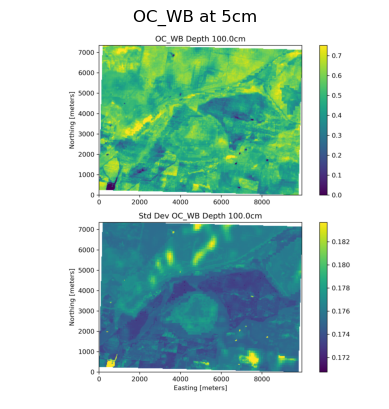

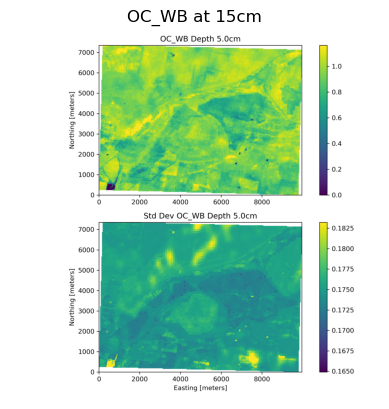

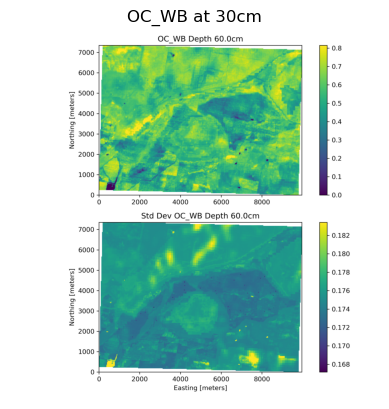

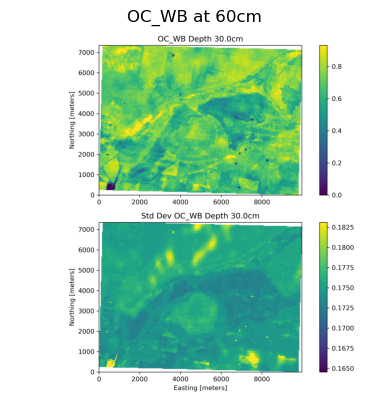

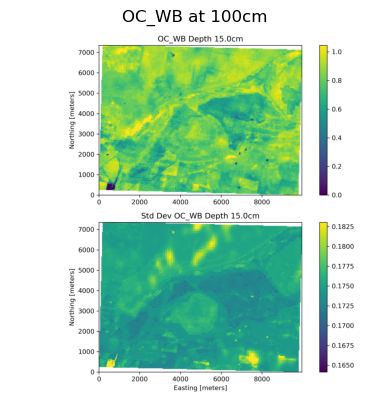

In [6]:
imgpath = os.path.join(settings.outpath, 'Figures_zslices')
files = os.listdir(imgpath)
# select depth png files
pngfiles = [name for name in files if name.endswith('cm.png')]
print('Image files generated: ', pngfiles)

nimg = len(pngfiles)
for i in range(len(pngfiles)):
    fig, ax = plt.subplots(1, dpi =100)
    img = imread(f"{imgpath}/{pngfiles[i]}", format='PNG')
    ax.set_axis_off()
    ax.imshow(img)
    ax.set_title(f'{settings.name_target} at {int(settings.list_z_pred[i]*100)}cm')
    fig.show()

### Averaged Top Soil Moisture Prediction in 2020

This figure shows the averaged prediction over the time slices above.

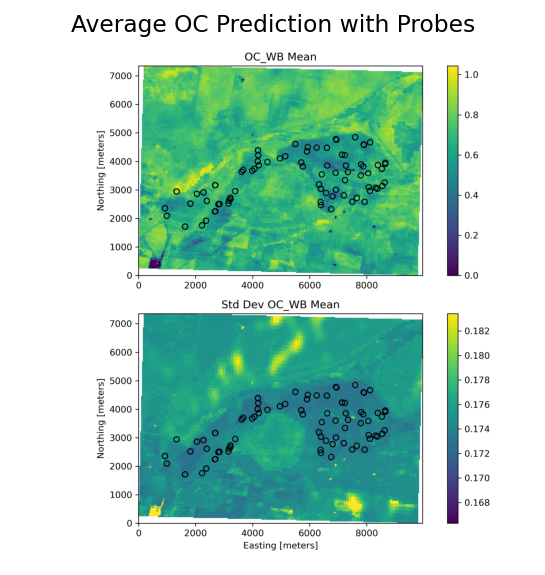

In [7]:
    fig, ax = plt.subplots(1, dpi =140)
    img = imread(f"{imgpath}/Pred_{settings.name_target}_mean.png", format='PNG')
    ax.set_axis_off()
    ax.imshow(img)
    ax.set_title('Average OC Prediction with Probes')
    plt.show()